2025-03-24 20:39:20.128521: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 20:39:20.157565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742819960.191563  166771 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742819960.200971  166771 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742819960.224531  166771 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 


Processing U11.SI...


2025-03-24 20:39:24.642253: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


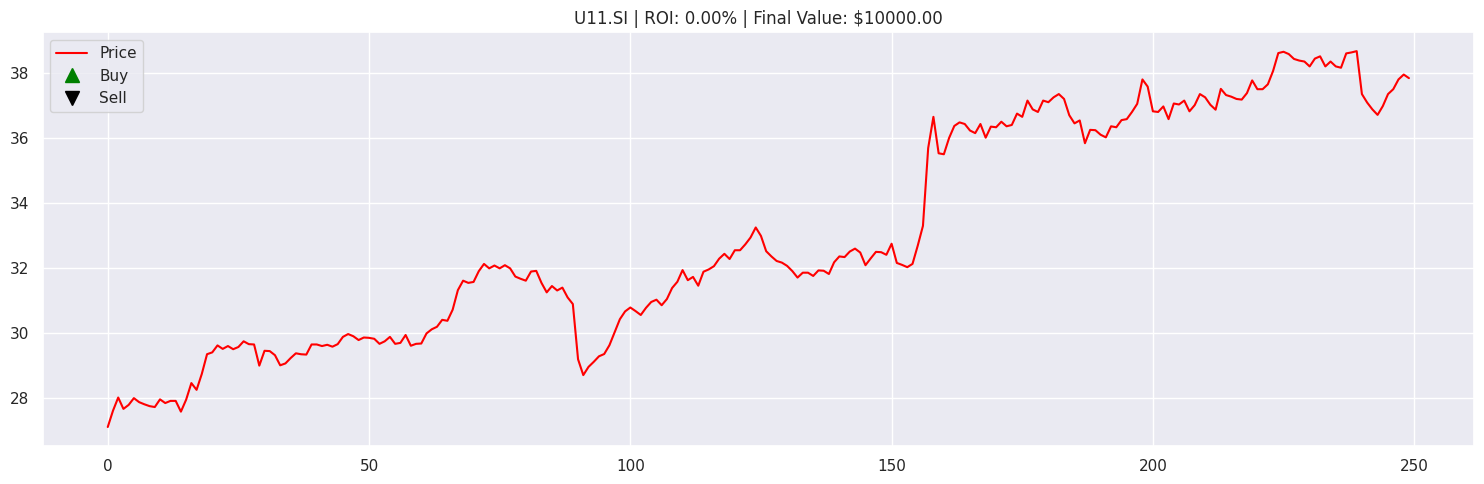


Processing C38U.SI...


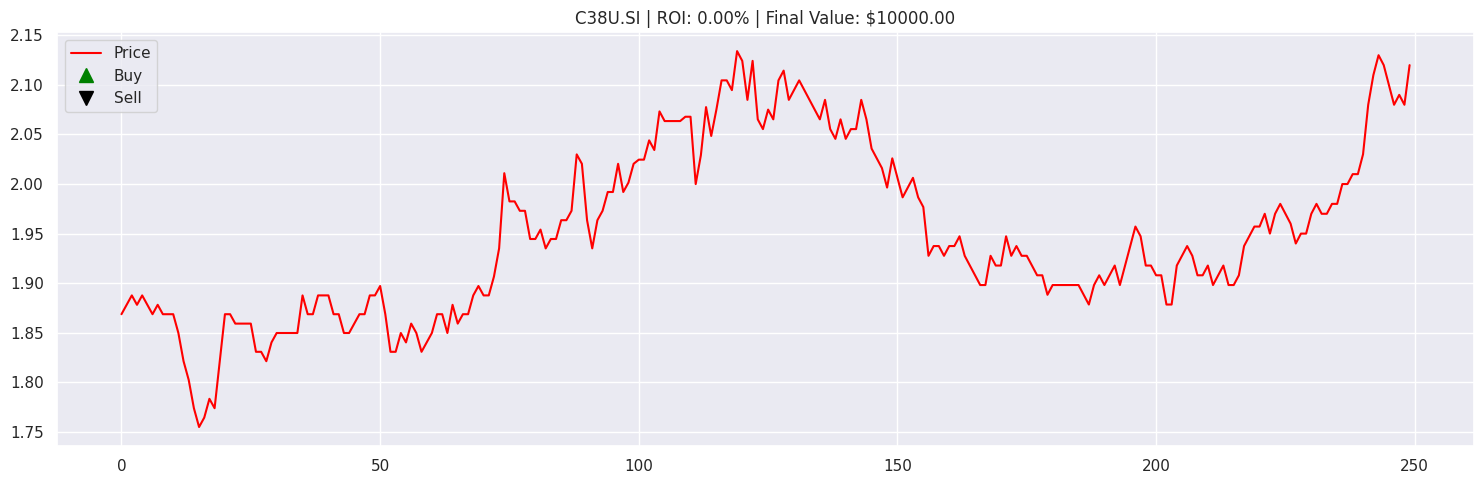


Processing Q0F.SI...


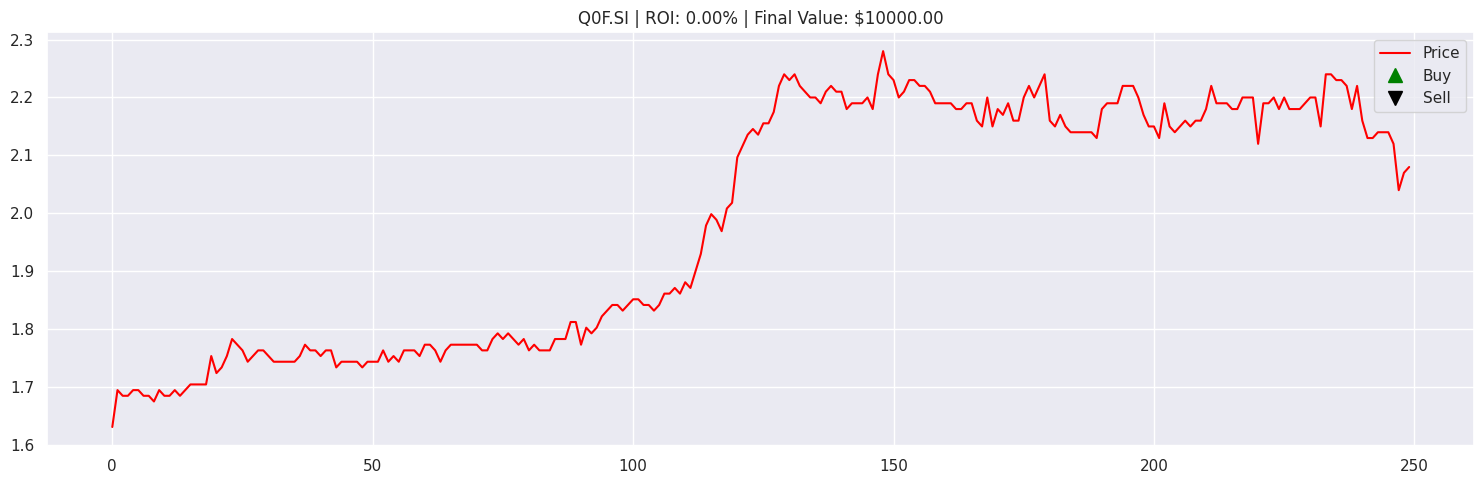


Processing S68.SI...


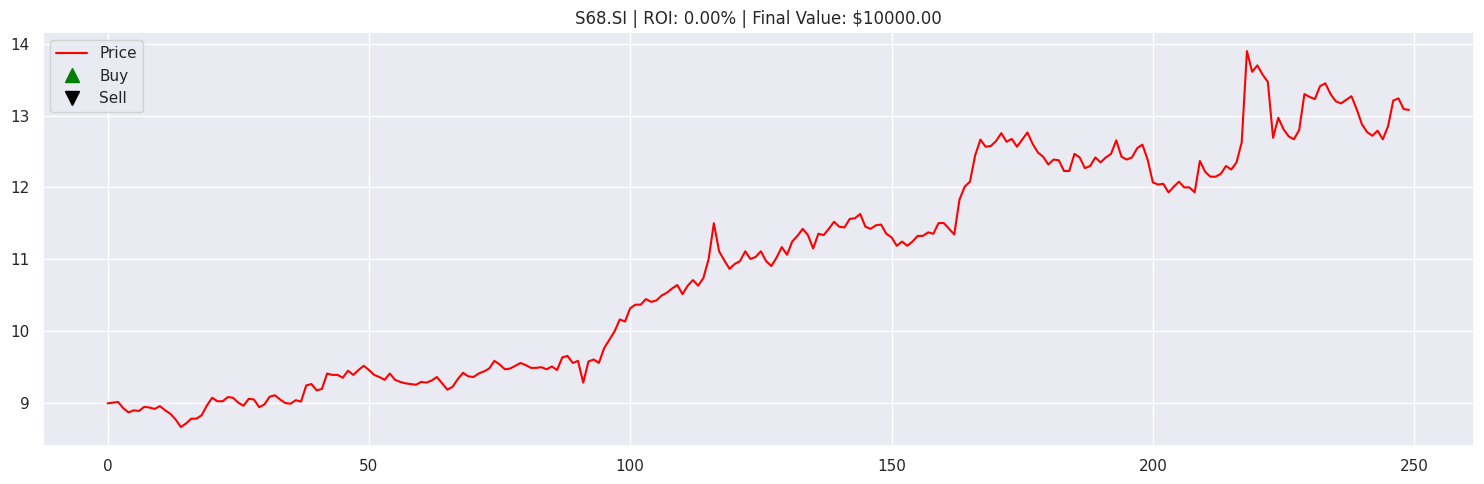


Processing S63.SI...


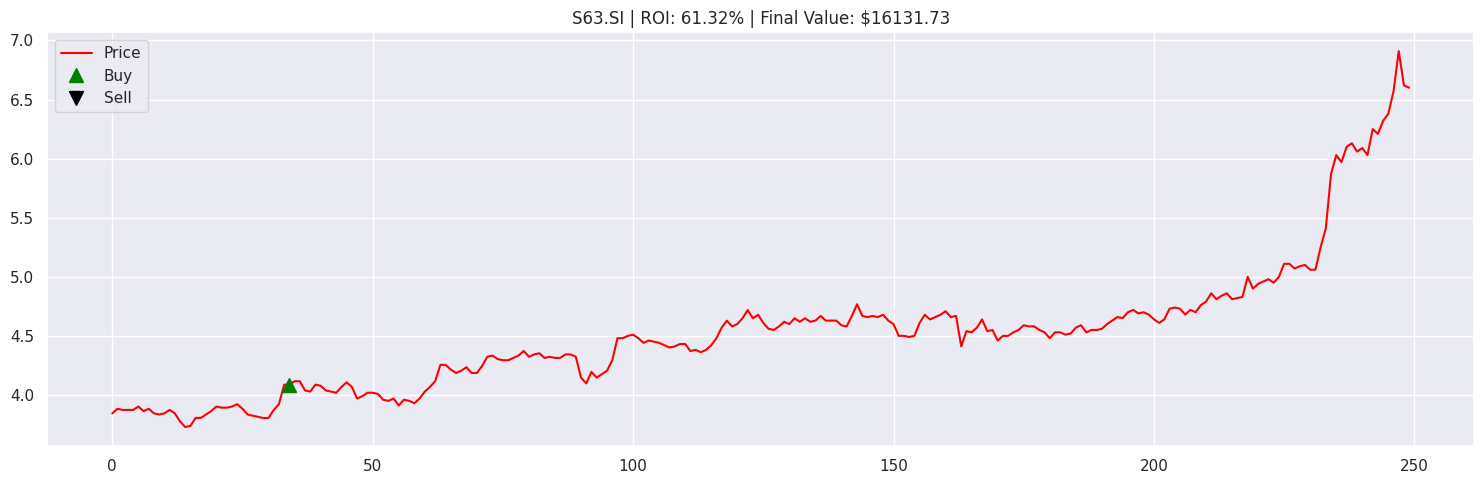


Processing AJBU.SI...


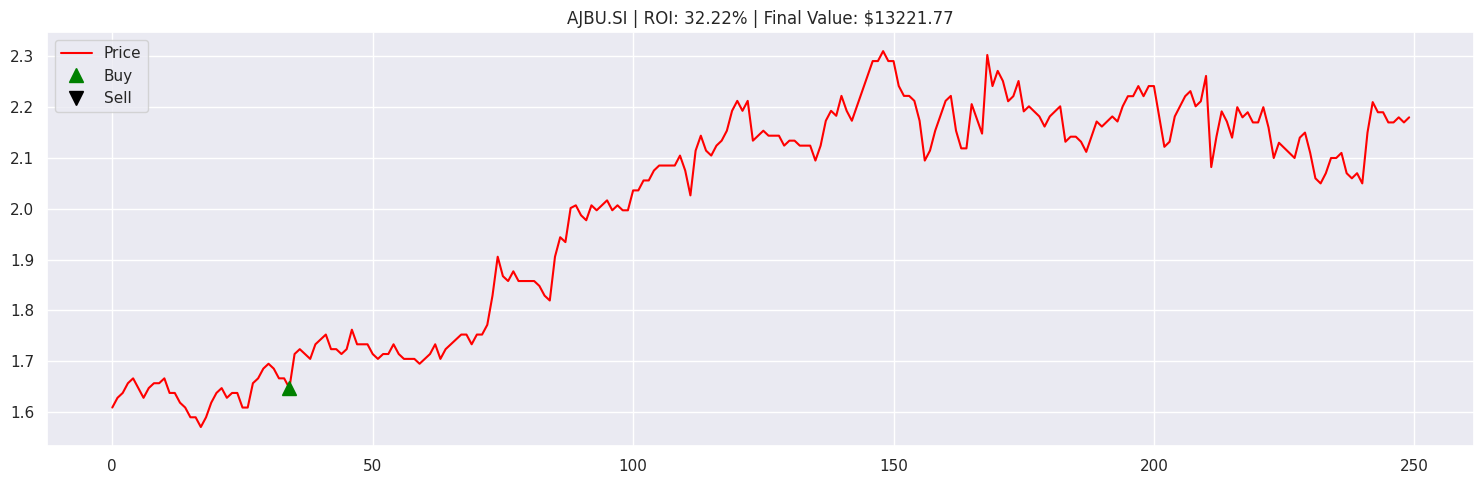


Portfolio Summary:
               ROI   Final Value
U11.SI    0.000000  10000.000000
C38U.SI   0.000000  10000.000000
Q0F.SI    0.000000  10000.000000
S68.SI    0.000000  10000.000000
S63.SI   61.317297  16131.729739
AJBU.SI  32.217664  13221.766437


OSError: Cannot save file into a non-existent directory: '/home/priya/Desktop/fyp/Agents/agents'

In [1]:
# Further Enhanced: Long-Term RL Strategy with Adaptive Signal Blending, Trend Confirmation & Dynamic Scaling + Double/Dueling/Recurrent Q-Learning Agent

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

sns.set()

# Parameters
initial_money = 10000
window_size = 30
commission = 0.001
alpha_threshold = 0.004
beta_threshold = -0.004
risk_rsi_low = 30
risk_rsi_high = 70
min_trade_profit = 0.002
volatility_buffer = 0.008
trend_confirm_window = 10
macd_weight = 0.5
rsi_weight = 0.3
trend_weight = 0.2


def RMA(series, period):
    rma = [series[0]]
    alpha = 1 / period
    for price in series[1:]:
        rma.append((1 - alpha) * rma[-1] + alpha * price)
    return np.array(rma)


def apply_second_order_rma(prices):
    return RMA(RMA(prices, 25), 9)


def compute_macd(prices, short=12, long=26, signal=9):
    ema_short = pd.Series(prices).ewm(span=short).mean()
    ema_long = pd.Series(prices).ewm(span=long).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line.values, signal_line.values


def compute_rsi(prices, period=14):
    delta = np.diff(prices)
    up = np.where(delta > 0, delta, 0)
    down = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(up).rolling(window=period).mean()
    avg_loss = pd.Series(down).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return np.concatenate([np.full(period, np.nan), rsi[period:]])


def compute_volatility(prices):
    returns = np.diff(prices) / prices[:-1]
    return np.std(returns[-10:])


def is_uptrend(prices):
    trend = np.polyfit(range(len(prices)), prices, 1)[0]
    return trend > 0


class DoubleDuelingRQLAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.model = self._build_model()

    def _build_model(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(64, activation='relu')(inputs)
        x = tf.keras.layers.Reshape((1, -1))(x)
        lstm = tf.keras.layers.LSTM(64, return_sequences=False)(x)
        value = tf.keras.layers.Dense(1)(lstm)
        advantage = tf.keras.layers.Dense(self.action_size)(lstm)
        q_values = tf.keras.layers.Lambda(lambda x: x[0] + (x[1] - tf.keras.backend.mean(x[1], axis=1, keepdims=True)))([value, advantage])
        model = tf.keras.Model(inputs=inputs, outputs=q_values)
        model.compile(optimizer='adam', loss='mse')
        return model

    def get_state(self, t, trend):
        d = t - window_size + 1
        block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
        delta = [block[i+1] - block[i] for i in range(window_size - 1)]
        rma2 = apply_second_order_rma(block)[-1]
        macd_line, signal_line = compute_macd(block)
        rsi = compute_rsi(block)
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        return np.array(delta + [rma2, macd_diff, rsi_val])

    def get_action(self, state):
        q_values = self.model.predict(np.array([state]), verbose=0)[0]
        return np.argmax(q_values)


portfolio_results = {}
tickers =  {
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": "ST Engineering",
    "AJBU.SI": "Keppel DC REIT"
}



for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
    close = df['Close'].values.tolist()
    if len(close) < window_size + 20:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    agent = DoubleDuelingRQLAgent(window_size - 1 + 3, 3)
    portfolio = initial_money
    shares_held = 0
    states_buy, states_sell = [], []

    for t in range(window_size, len(close) - 1):
        state = agent.get_state(t, close)
        macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi = compute_rsi(close[max(0, t-50):t+1])
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        vol = compute_volatility(close[max(0, t-20):t+1])
        trend_score = 1 if is_uptrend(close[max(0, t-trend_confirm_window):t+1]) else -1

        weighted_signal = macd_weight * macd_diff + rsi_weight * ((50 - rsi_val) / 50) + trend_weight * trend_score
        current_price = close[t]
        expected_profit = close[t+1] * (1 - commission) - current_price * (1 + commission)

        action = agent.get_action(state)

        if action == 1 and weighted_signal > alpha_threshold and expected_profit > min_trade_profit * current_price and vol > volatility_buffer and portfolio >= current_price * (1 + commission):
            shares_to_buy = portfolio // (current_price * (1 + commission))
            portfolio -= shares_to_buy * current_price * (1 + commission)
            shares_held += shares_to_buy
            states_buy.append(t)

        elif action == 2 and weighted_signal < beta_threshold and shares_held > 0 and vol > volatility_buffer:
            portfolio += shares_held * current_price * (1 - commission)
            shares_held = 0
            states_sell.append(t)

    portfolio_value = portfolio + shares_held * close[-1]
    roi = (portfolio_value - initial_money) / initial_money * 100
    portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

    plt.figure(figsize=(15, 5))
    plt.plot(close, label='Price', color='red')
    plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
    plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(portfolio_results).T
print("\nPortfolio Summary:")
print(results_df)
results_df.to_csv("/home/priya/Desktop/fyp/Agents/agents/results_doubleduelrql.csv")

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Final ROI per Stock")
plt.ylabel("ROI (%)")
plt.xlabel("Stock Ticker")
plt.tight_layout()
plt.show()